In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# this allows us to import from the src folder
SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

sns.set_theme(style="whitegrid")

In [18]:
final_data_path = cfg.FIN_MERGED / "model_ready_dataset.parquet"
print(f"Loading final dataset from: {final_data_path}")

try:
    df = pd.read_parquet(final_data_path)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: The file {final_data_path.name} was not found. Please run build_model_dataset.py first.")

Loading final dataset from: D:\Air pollution london\data\final\aq_traffic\model_ready_dataset.parquet
Dataset loaded successfully.
Shape of the dataset: (499571, 29)


In [20]:
print("--- Dataframe Info ---")
df.info()

print("\n--- Statistical Summary ---")
print(df.describe())

--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499571 entries, 0 to 499570
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   date                  499571 non-null  datetime64[ns, UTC]
 1   site_code             499571 non-null  object             
 2   site_name             499571 non-null  object             
 3   latitude              499571 non-null  float64            
 4   longitude             499571 non-null  float64            
 5   NO2                   499571 non-null  float64            
 6   PM2.5                 499571 non-null  float64            
 7   temperature_2m        499571 non-null  float64            
 8   relative_humidity_2m  499571 non-null  float64            
 9   dew_point_2m          499571 non-null  float64            
 10  precipitation         499571 non-null  float64            
 11  snow_depth            499571 

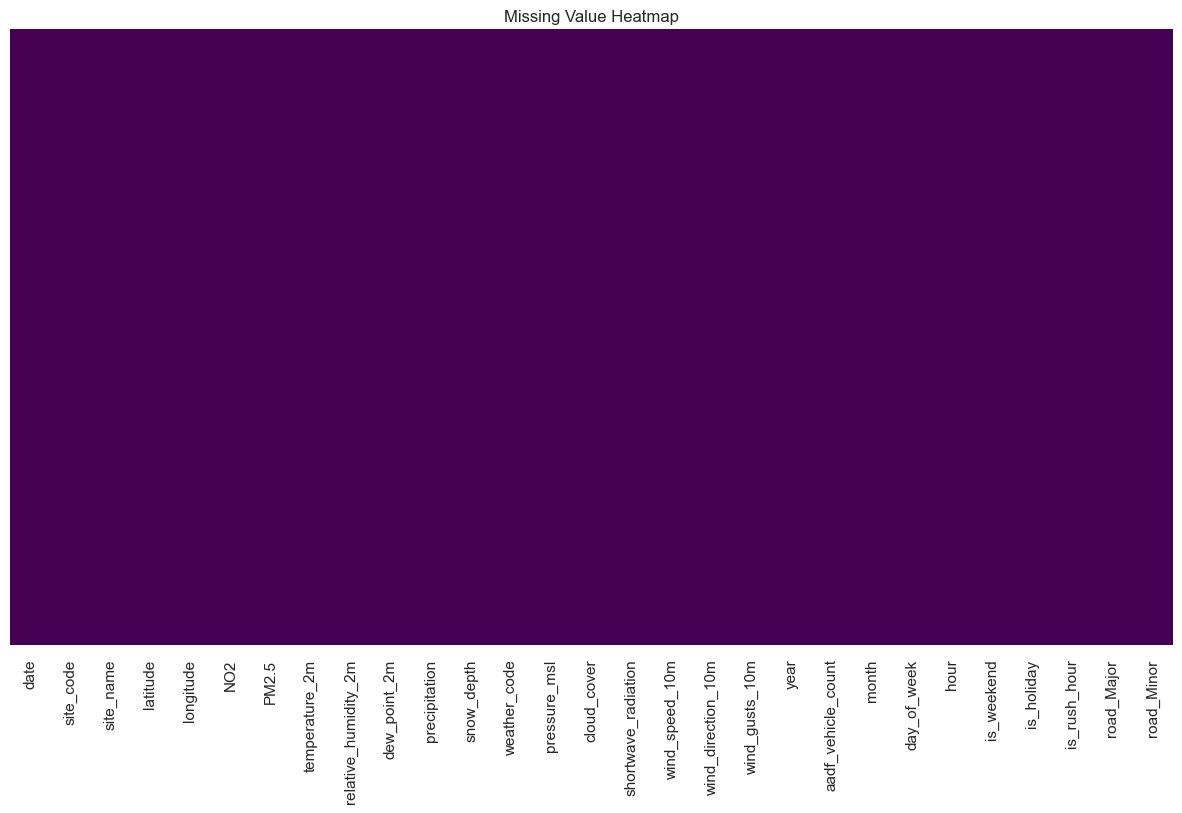


Percentage of missing values per column:
Series([], dtype: float64)


In [8]:
# heatmap to visualize the pattern of missing data
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

# also print the percentages
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("\nPercentage of missing values per column:")
print(missing_percent[missing_percent > 0])

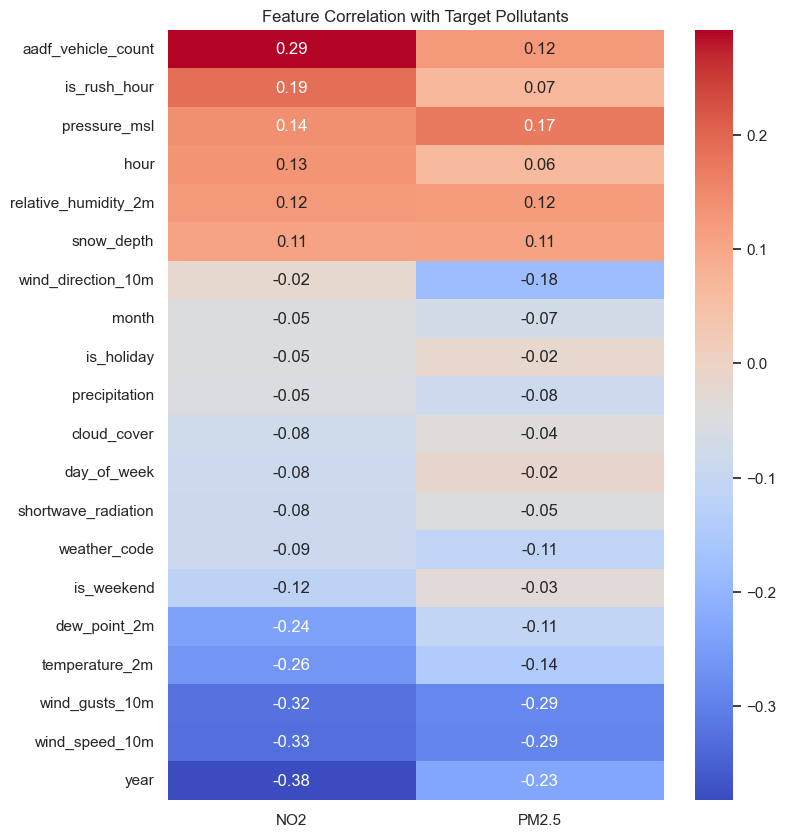

In [22]:
# Correlation Heatmap

# select only the numeric columns for the correlation calculation
numeric_df = df.select_dtypes(include=np.number)

# define the cyclical and redundant columns we want to exclude from this specific plot
cols_to_exclude = [col for col in numeric_df.columns if '_sin' in col or '_cos' in col]
# also exclude the one-hot encoded weather codes from this heatmap
cols_to_exclude += [col for col in numeric_df.columns if 'wc_' in col]

# calculate the correlation matrix on the simplified feature set
corr_matrix_simple = numeric_df.drop(columns=cols_to_exclude).corr()

# isolate the correlations with our target variables
target_corr = corr_matrix_simple[['NO2', 'PM2.5']].drop(['NO2', 'PM2.5', 'latitude', 'longitude'])

# create the heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(
    target_corr.sort_values(by='NO2', ascending=False), 
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Feature Correlation with Target Pollutants')
plt.show()

C:\Users\clown\AppData\Local\Temp\ipykernel_504\1603046781.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df, x='is_weekend', y='NO2', palette='pastel')
C:\Users\clown\AppData\Local\Temp\ipykernel_504\1603046781.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Weekday (0)', 'Weekend (1)'])
C:\Users\clown\AppData\Local\Temp\ipykernel_504\1603046781.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df, x='is_holiday', y='NO2', palette='pastel')
C:\Users\clown\AppData\Local\Temp\ipykernel_504\1603046781.py:14: UserWarning: set_ticklabels() 

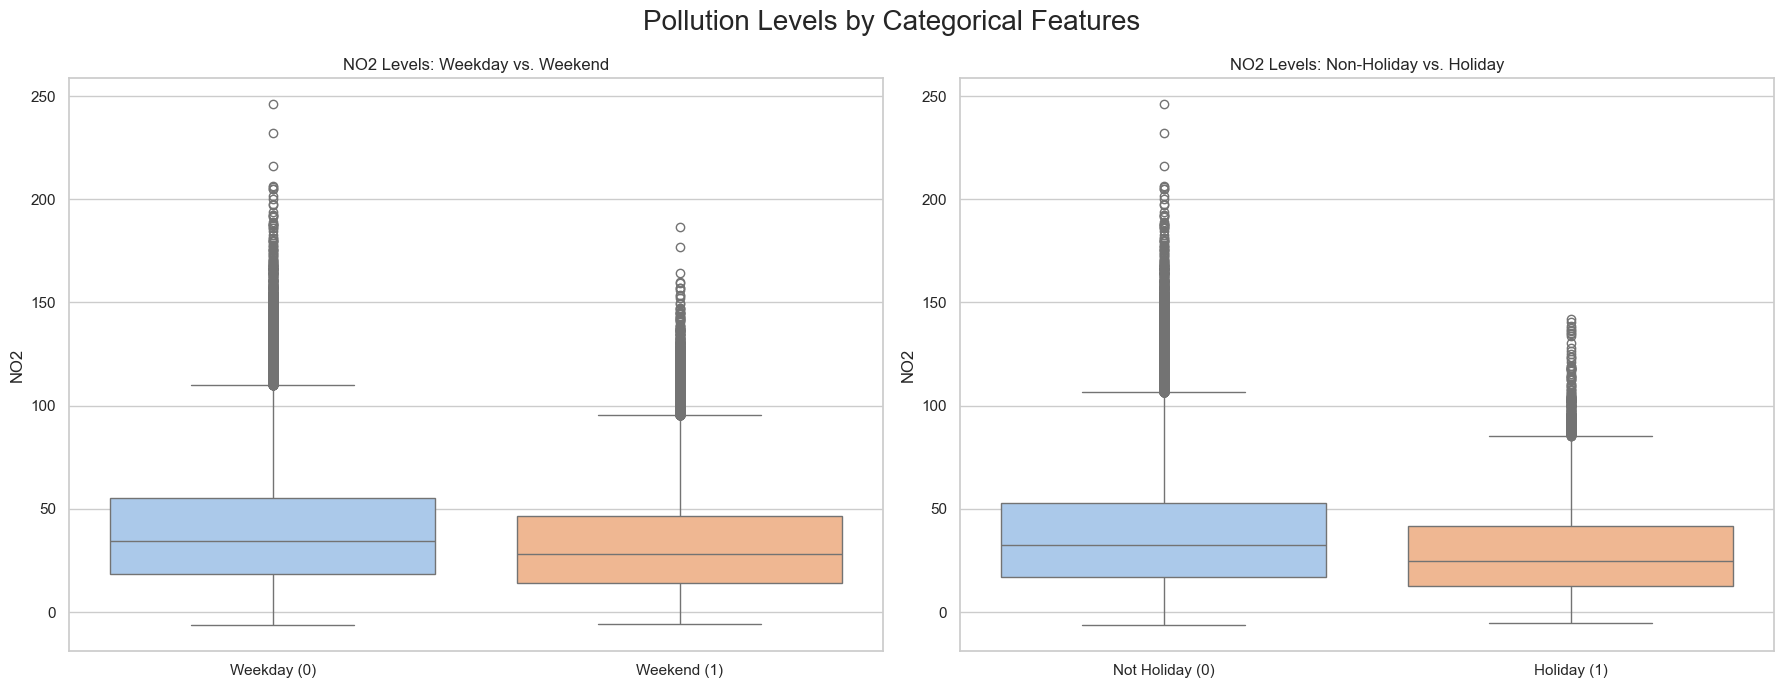

In [8]:
# create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Pollution Levels by Categorical Features', fontsize=20)

# a. is_weekend vs. no2
sns.boxplot(ax=axes[0], data=df, x='is_weekend', y='NO2', palette='pastel')
axes[0].set_title('NO2 Levels: Weekday vs. Weekend')
axes[0].set_xticklabels(['Weekday (0)', 'Weekend (1)'])
axes[0].set_xlabel('')

# b. is_holiday vs. no2
sns.boxplot(ax=axes[1], data=df, x='is_holiday', y='NO2', palette='pastel')
axes[1].set_title('NO2 Levels: Non-Holiday vs. Holiday')
axes[1].set_xticklabels(['Not Holiday (0)', 'Holiday (1)'])
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

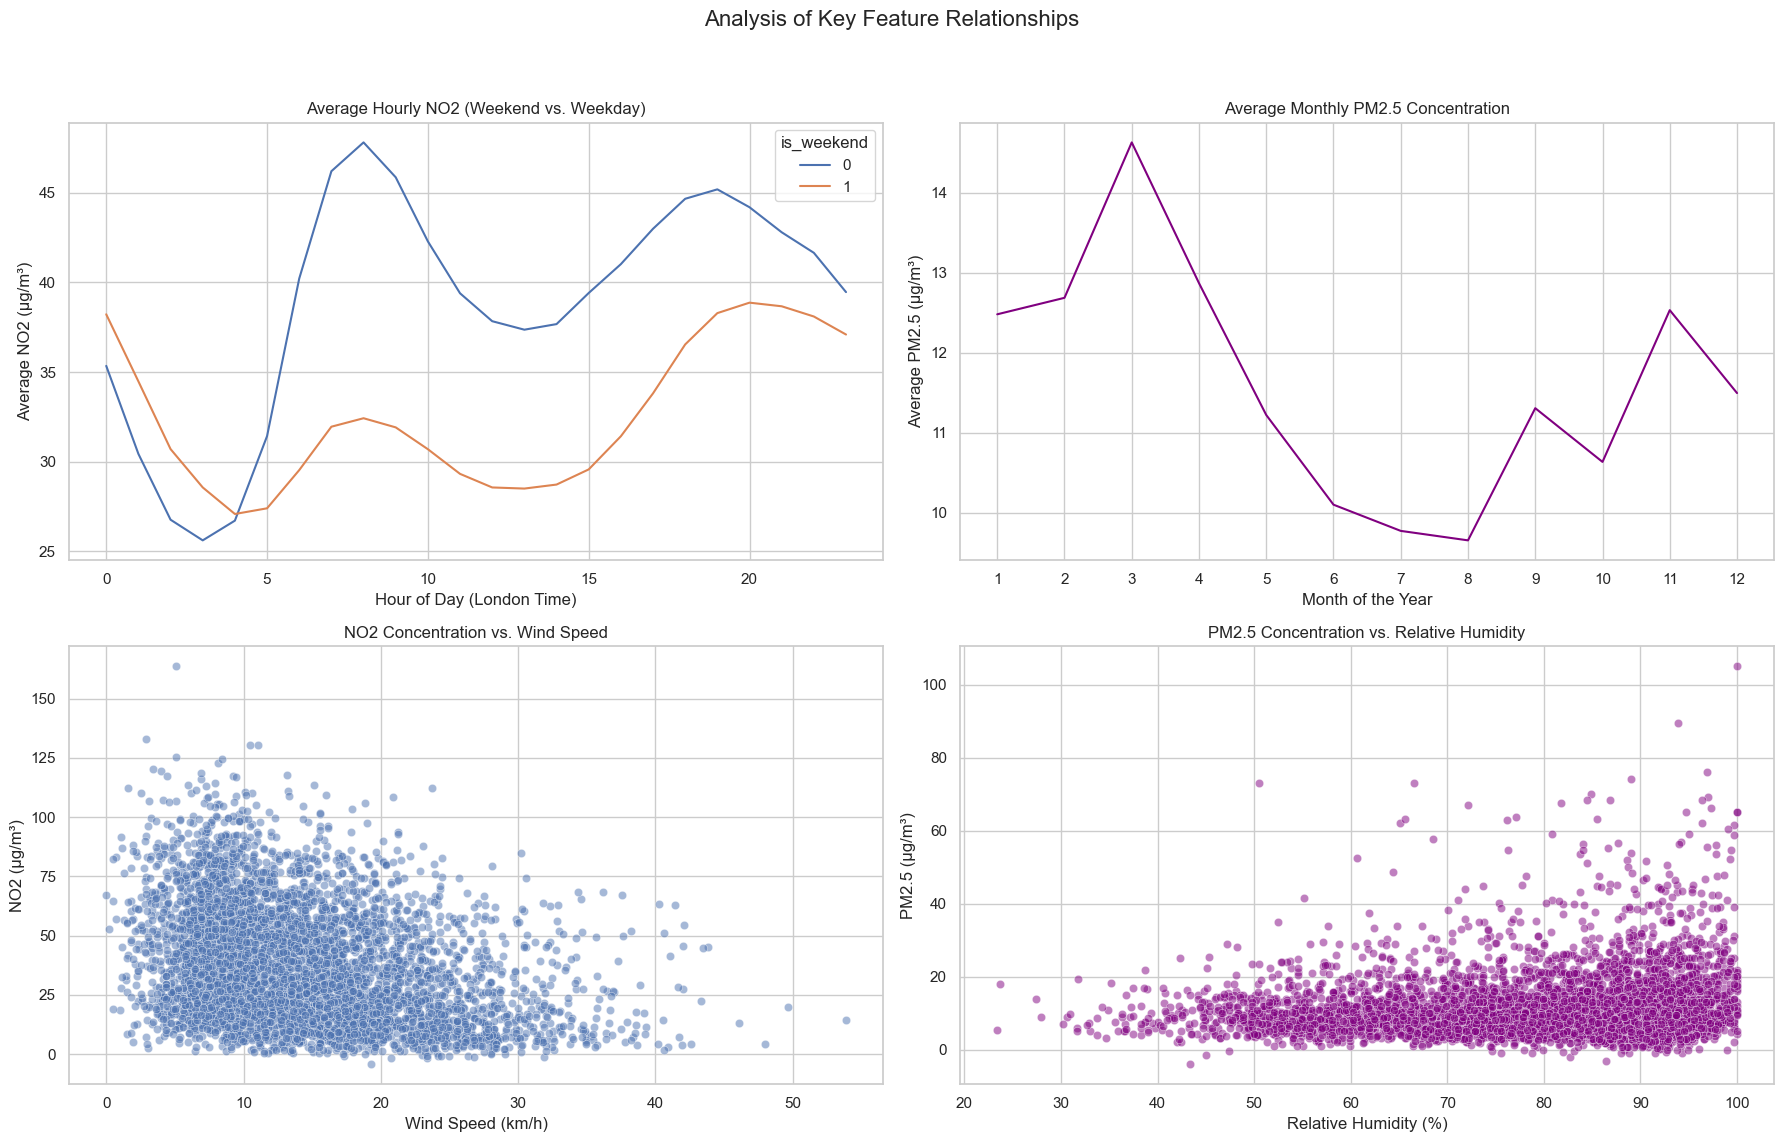

In [16]:
# create a sample for scatter plots to keep them readable
df_sample = df.dropna(subset=['NO2', 'PM2.5']).sample(n=5000, random_state=42)

# setup the plot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Analysis of Key Feature Relationships', fontsize=16)

# 1. hourly pattern of no2 - using the original 'hour' column
sns.lineplot(data=df, x='hour', y='NO2', hue='is_weekend', ax=axes[0, 0], errorbar=None)
axes[0, 0].set_title('Average Hourly NO2 (Weekend vs. Weekday)')
axes[0, 0].set_xlabel('Hour of Day (London Time)')
axes[0, 0].set_ylabel('Average NO2 (µg/m³)')
axes[0, 0].grid(True)

# 2. seasonal (monthly) pattern of pm2.5 - using the original 'month' column
sns.lineplot(data=df, x='month', y='PM2.5', ax=axes[0, 1], errorbar=None, color='purple')
axes[0, 1].set_title('Average Monthly PM2.5 Concentration')
axes[0, 1].set_xlabel('Month of the Year')
axes[0, 1].set_ylabel('Average PM2.5 (µg/m³)')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True)

# 3. no2 vs. wind speed
sns.scatterplot(data=df_sample, x='wind_speed_10m', y='NO2', alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('NO2 Concentration vs. Wind Speed')
axes[1, 0].set_xlabel('Wind Speed (km/h)')
axes[1, 0].set_ylabel('NO2 (µg/m³)')

# 4. pm2.5 vs. relative humidity
sns.scatterplot(data=df_sample, x='relative_humidity_2m', y='PM2.5', alpha=0.5, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('PM2.5 Concentration vs. Relative Humidity')
axes[1, 1].set_xlabel('Relative Humidity (%)')
axes[1, 1].set_ylabel('PM2.5 (µg/m³)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

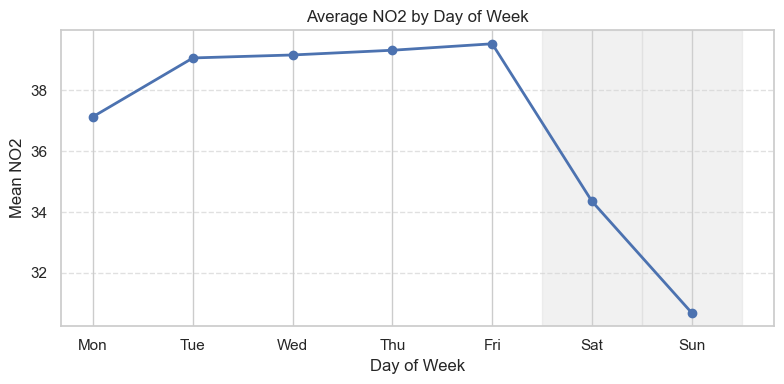

In [12]:
# 2) Group by day and take the mean NO₂
weekly_no2 = (
    df
      .groupby('day_of_week')['NO2']
      .mean()
      .reindex(range(7))  # ensure Monday to Sunday order
)

# 3) Map to names
day_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# 4) Plot
plt.figure(figsize=(8,4))
plt.plot(day_names, weekly_no2, marker='o', linewidth=2)
plt.title('Average NO2 by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Mean NO2')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Shade the weekend days
for i in [5,6]:
    plt.axvspan(i-0.5, i+0.5, color='lightgrey', alpha=0.3)

plt.tight_layout()
plt.show()

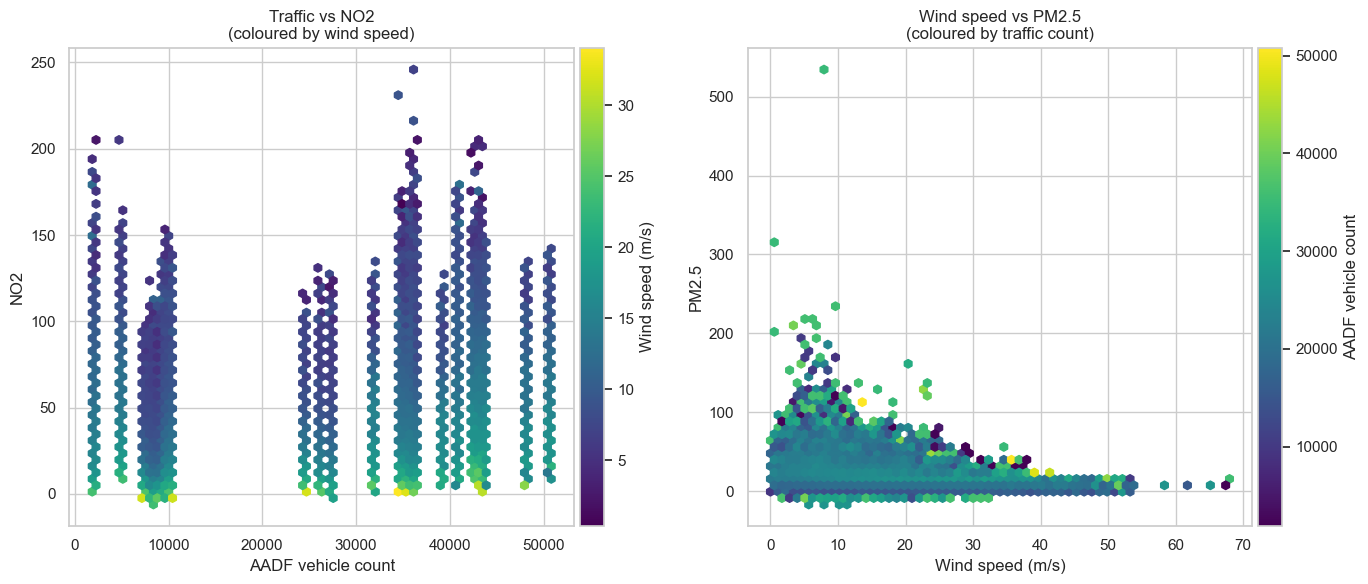

In [27]:
df_clean = df.dropna(subset=['NO2', 'PM2.5', 'aadf_vehicle_count', 'wind_speed_10m']).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Traffic vs NO2, coloured by wind speed
hb1 = axes[0].hexbin(
    df_clean['aadf_vehicle_count'],
    df_clean['NO2'],
    C=df_clean['wind_speed_10m'],
    gridsize=60,
    reduce_C_function=np.mean,
    cmap='viridis'
)
axes[0].set_xlabel('AADF vehicle count')
axes[0].set_ylabel('NO2')
axes[0].set_title('Traffic vs NO2\n(coloured by wind speed)')
cb1 = fig.colorbar(hb1, ax=axes[0], pad=0.01)
cb1.set_label('Wind speed (m/s)')

# Right: Wind speed vs PM2.5, coloured by traffic
hb2 = axes[1].hexbin(
    df_clean['wind_speed_10m'],
    df_clean['PM2.5'],
    C=df_clean['aadf_vehicle_count'],
    gridsize=60,
    reduce_C_function=np.mean,
    cmap='viridis'
)
axes[1].set_xlabel('Wind speed (m/s)')
axes[1].set_ylabel('PM2.5')
axes[1].set_title('Wind speed vs PM2.5\n(coloured by traffic count)')
cb2 = fig.colorbar(hb2, ax=axes[1], pad=0.01)
cb2.set_label('AADF vehicle count')

plt.tight_layout()
plt.show()
